## Calculate ZDR Bias From QVP

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import num2date
import matplotlib.dates as mdates
import os, glob
import pyart
import xarray as xr

# ****************************************************************************************

def retrieve_qvp(filename, flds = None):
    if flds == None:
        flds = ['PH','RH','SW','CZ','DR']
    radar = pyart.io.read(filename)
    desired_angle = 20.0
    index = abs(radar.fixed_angle['data'] - desired_angle).argmin()
    #print(radar.fixed_angle['data'])
    #print(radar.elevation['data'][-1])
    qvp = {}
    for fld in flds:
        this_fld = radar.get_field(index, fld).mean(axis = 0)
        qvp.update({fld:this_fld})
    qvp.update({'range': radar.range['data'], 'time': radar.time})
    x,y,z = pyart.core.transforms.antenna_to_cartesian(qvp['range']/1000.0, 0.0, 
                                             radar.fixed_angle['data'][index])
    qvp.update({'height': z})
    del radar
    return qvp

# ****************************************************************************************

def extract_ice_phase_data(ds, min_height, max_height):
    
    # Extract ZDR values in the ice phase region between min_height and max_height.
    # Select the data within the ice-phase height range
    
    ice_phase_data = ds['DR'].sel({'height': slice(min_height, max_height)})
    return ice_phase_data.values

# ****************************************************************************************

def calculate_zdr_offset(zdr_values):
    
    # Calculate the ZDR calibration offset.
    # The expected theoretical ZDR in the ice phase is 0 dB.

    mean_zdr = np.nanmean(zdr_values)
    offset = -mean_zdr  # Target is 0 dB
    return offset


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### Read in a full day and create QVP dictionary

In [3]:
in_dir = '/Users/jpippitt/GPM-GV/KPOL/150310/'
wc = in_dir + '*.cf'
all_files = sorted(glob.glob(wc))

result = []
for file in all_files:
    result.append(retrieve_qvp(file))
kpol_qvps = result

### Organize data into a time series

In [4]:
# Create an empty dictionary to be filled
kpol_time_series = {}

# Work out how many profiles
n_times = len(kpol_qvps)

# Loop over all fields 
for fld in ['PH','RH','SW','CZ', 'DR']:
    # Create empty time series
    this_fld = np.zeros([n_times, len(kpol_qvps[0][fld])])
    
    # Create time array
    kpol_times = np.zeros(n_times)
    
    # Loop over all times
    for i in range(n_times):
        
        # Create a datetime object
        dateobj = num2date(kpol_qvps[i]['time']['data'][0], kpol_qvps[i]['time']['units'])
        
        # Append a numerical date using Matplotlib's time reference
        kpol_times[i] = mdates.date2num(dateobj)
        
        # Update the profile to the time series
        this_fld[i,:] = kpol_qvps[i][fld]
    
    # Append the time series to the dictionary
    kpol_time_series.update({fld: this_fld[kpol_times.argsort(), :]})
    
# Sort times    
kpol_times.sort()


### Plot CZ

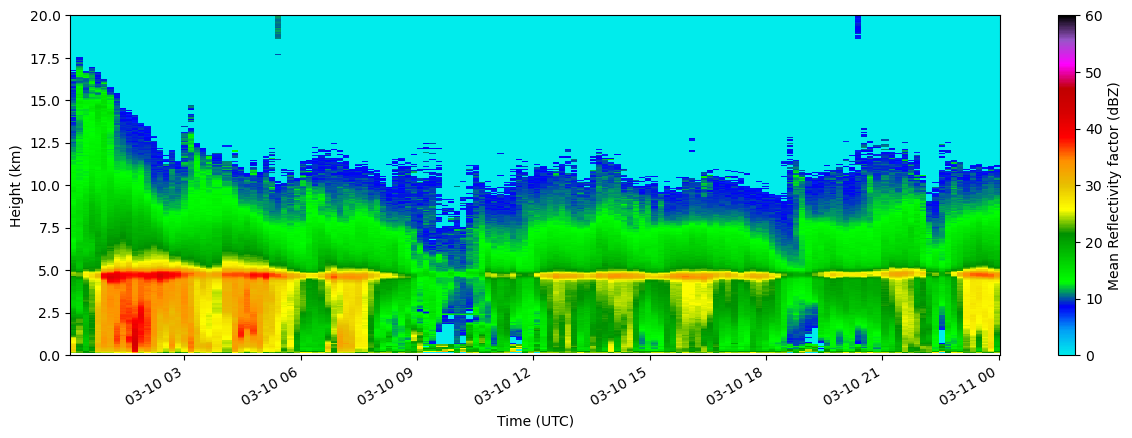

In [5]:
fig = plt.figure(figsize = [15,5])

pc = plt.pcolormesh(kpol_times, kpol_qvps[0]['height']/1000.0, 
                    kpol_time_series['CZ'].transpose(),
                    vmin = 0, vmax = 60, cmap=pyart.graph.cm.NWSRef)
ax = plt.gca()
ax.xaxis_date()
fig.autofmt_xdate()
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
plt.ylim([0,20])
cb = plt.colorbar()
cb.set_label('Mean Reflectivity factor (dBZ)')
plt.show()

### Plot ZDR

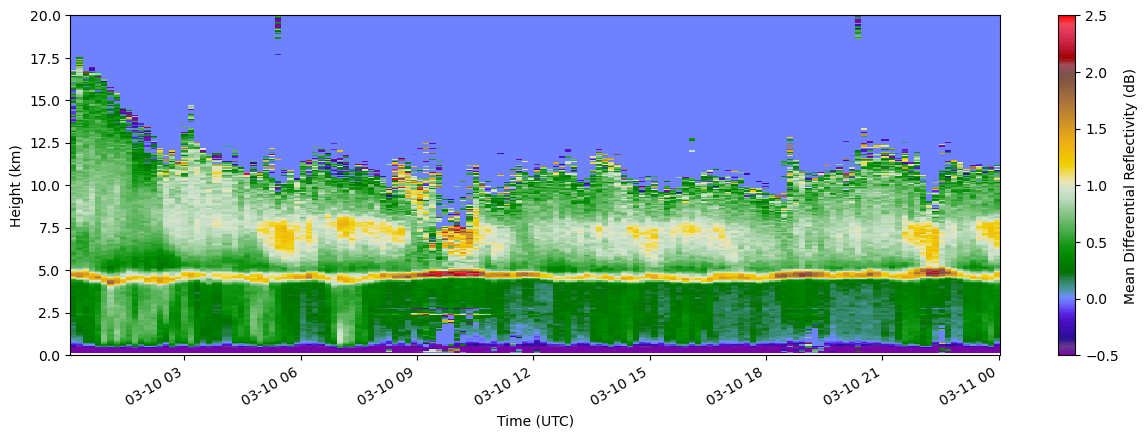

In [6]:
fig = plt.figure(figsize = [15,5])
pc = plt.pcolormesh(kpol_times, kpol_qvps[0]['height']/1000.0, 
                    kpol_time_series['DR'].transpose(),
                    vmin = -0.5, vmax = 2.5, cmap=pyart.graph.cm.Carbone42)

ax = plt.gca()
ax.xaxis_date()
fig.autofmt_xdate()
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
plt.ylim([0,20])
cb = plt.colorbar()
cb.set_label('Mean Differential Reflectivity (dB)')
plt.show()

### Convert dictionary to xarray Dataset

In [7]:
# Convert dictionary to xarray Dataset

ds = xr.Dataset(
    {
        "DR": (["time", "height"], kpol_time_series["DR"]),
        "KD": (["time", "height"], kpol_time_series["RH"]),
        "CZ": (["time", "height"], kpol_time_series["CZ"]),
        "PH": (["time", "height"], kpol_time_series["PH"]),
        "SW": (["time", "height"], kpol_time_series["SW"]),
    },
    coords={
        "time": kpol_times,
        "height": kpol_qvps[0]['height']
    }
)

print(ds)

<xarray.Dataset> Size: 5MB
Dimensions:  (time: 149, height: 779)
Coordinates:
  * time     (time) float64 1kB 1.65e+04 1.65e+04 1.65e+04 ... 1.65e+04 1.65e+04
  * height   (height) float64 6kB 177.6 248.6 319.7 ... 5.661e+04 5.668e+04
Data variables:
    DR       (time, height) float64 929kB -2.868 -1.978 -1.694 ... 0.0 0.0 0.0
    KD       (time, height) float64 929kB 0.8872 0.9379 0.9602 ... 0.0 0.0 0.0
    CZ       (time, height) float64 929kB 23.96 28.21 29.16 ... 0.0 0.0 0.0
    PH       (time, height) float64 929kB 259.2 256.1 251.0 ... 0.0 0.0 0.0
    SW       (time, height) float64 929kB 0.6846 0.9521 0.9743 ... 0.0 0.0 0.0


In [10]:
# Obtain min and max height from plots above
min_height = 5500
max_height = 9000

# Extract ZDR values within ice
zdr_values = extract_ice_phase_data(ds, min_height, max_height)

# Compute the calibration offset
offset = calculate_zdr_offset(zdr_values)
print(f"ZDR Calibration offset: {offset:.2f} dB")

ZDR Calibration offset: -0.82 dB
